# Tweet Text Sentiment Analysis Project

## Executive Summary

This project develops a sentiment analysis model for Tweets about Apple and Google products to provide insights into public opinion. The dataset, containing over 9,000 labeled Tweets (positive, negative, or neutral), required thorough pre-processing, including text cleaning, tokenization, and handling class imbalances using SMOTE. Two classification approaches were employed: binary classification (positive vs. negative) and multiclass classification (positive, negative, neutral). Various models, including Logistic Regression, Random Forest, and Support Vector Machine (SVM), were tested for binary classification, while Multinomial Naive Bayes and an ensemble model were used for multiclass classification.

Logistic Regression was found to be the most balanced binary classification model, achieving 88% accuracy and demonstrating strong performance in detecting negative sentiment, with an F1-score of 0.62. For multiclass classification, the ensemble model outperformed the standalone Naive Bayes model, achieving 68% accuracy and improved precision for the negative class. Evaluation metrics such as accuracy, precision, recall, F1-score, and AUC-ROC were used to assess the models' performance, with F1-score being critical due to class imbalance. 

The findings demonstrate that the models can effectively classify sentiment, with the ensemble model providing a comprehensive view of consumer opinions across all sentiment classes. These insights will help Apple and Google improve customer engagement and product strategies. Recommendations include refining pre-processing, addressing class imbalances further, and retraining the models for continued relevance.

## Project Overview

This project aims to develop an advanced Natural Language Processing (NLP) model for analyzing sentiment in Tweets related to Apple and Google products. The dataset comprises over 9,000 Tweets labeled as positive, negative, or neutral by human raters. The objective is to create a robust generalized sentiment classification model that can accurately predict sentiment based on the content of the Tweets, providing Apple and Google with actionable insights for their marketing and product development teams. The goal is to help these stakeholders understand consumer perception, identify trends, and enhance customer engagement.

### Objectives:
1. **Develop a Sentiment Classification Model**:
   - Build an NLP model capable of accurately classifying Tweets as positive, negative, or neutral to help Apple and Google assess public opinion about their products.
2. **Evaluate Model Performance for Binary and Multiclass Classification**:
   - Optimize binary classification (positive vs. negative) and multiclass classification (positive, negative, neutral) to ensure high accuracy and balance across all classes, with a focus on improving the detection of negative sentiment.
3. **Provide Business Insights to Stakeholders**:
   - Use model results to provide insights on how Apple and Google can respond to public opinion, identify marketing opportunities, and enhance product development** strategies.

The models developed can be deployed to provide actionable insights for stakeholders at Apple and Google, ensuring they can monitor public sentiment effectively and make informed decisions for marketing and product development.

## Business Understanding

* **Stakeholder:** The primary stakeholders are the marketing and product development teams at Apple and Google. These teams seek to understand public sentiment towards their products to guide marketing strategies, product enhancements, and customer engagement initiatives.

* **Business Problem:** Apple and Google aim to monitor and analyze general consumer sentiment on social media platforms to gauge public perception and identify trends in how their products are received. A generalized sentiment analysis model based on Tweet content will help them quickly assess whether social media conversations about their products are positive, negative, or neutral. This will allow them to respond to broad public opinion more effectively, identify potential marketing opportunities, and enhance customer engagement.


## Data Understanding

* **Dataset:** The project utilizes a dataset from CrowdFlower via data.world, containing over 9,000 Tweets about Apple and Google products. Each Tweet annotated by human raters with a sentiment classification: positive, negative, or neutral.

* **Suitability:** This dataset is well-suited for the business problem as it provides a sizable and diverse collection of real-time consumer opinions. The multi-class sentiment labels facilitate both binary (positive/negative) and multi-class classification tasks, allowing for scalable model development.


## Data Exploration & Preparation

### Data Exploration

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [2]:
# Load the dataset to inspect its structure
tweet_data = pd.read_csv('./data_file/tweet_sentiments.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
tweet_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset consists of the following key columns:

* `tweet_text`: The actual text of the Tweet.
* `emotion_in_tweet_is_directed_at`: The product or brand mentioned in the Tweet (e.g., iPhone, iPad, Google).
* `is_there_an_emotion_directed_at_a_brand_or_product`: The sentiment or emotion expressed in the Tweet (e.g., Positive emotion, Negative emotion).

In [3]:
# Get a summary of the dataset, including data types and non-null counts
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset information:

- The dataset contains **9,093 entries** and **3 columns**.
- All the columns are of the data type **object** (textual data).
- The dataset has some missing values in the `tweet_text` and `emotion_in_tweet_is_directed_at` columns.

In [4]:
# Display a summary of the missing values
tweet_data.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

The missing values in the dataset:

- `tweet_text`: 1 missing value. We will drop the row containing the missing text. 
- `emotion_in_tweet_is_directed_at`: 5802 missing values - could suggest that for many tweets, the emotion is not directed at a specific brand or product.  We will thus drop this column because it is not crucial for sentiment classification as our primary target is the sentiment. It is also not rational to fill in all the missing values with mean, median or mode for this column.
- `is_there_an_emotion_directed_at_a_brand_or_product`: 0 missing values.

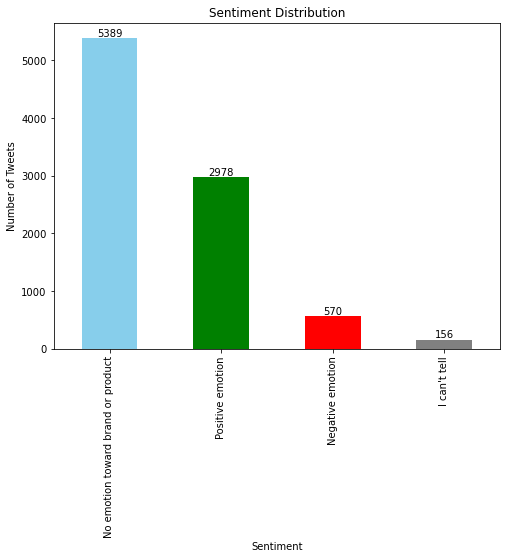

In [5]:
# Check the distribution of the sentiment
sentiment_distribution = tweet_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
ax = sentiment_distribution.plot(kind='bar', color=['skyblue', 'green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

The sentiment distribution shows a significant imbalance that needs to be addressed during pre-processing through appropriate methods. Majority of the tweets (5,389) have no emotion directed at a brand or product, while positive emotions (2,978) are significantly more represented than negative emotions (570). 156 instances are labeled as "I can't tell" which we could remove or filter out.

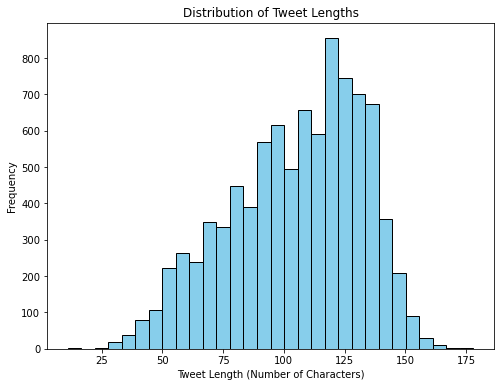

In [6]:
# Analyze the text length by calculating the number of characters in each tweet
tweet_lengths = tweet_data['tweet_text'].str.len()

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
plt.hist(tweet_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Most tweets appear to fall within a moderate length range, with the majority clustered between shorter lengths (as expected with tweet constraints). Since the dataset is not too huge, we will not truncate the tweets during tokenization.

In [7]:
# Count common words in the tweet_text
# Clean the tweet_text by dropping rows with missing text values
tweet_data_cleaned = tweet_data.dropna(subset=['tweet_text'])

# Tokenize the cleaned tweets by sentiment
positive_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['tweet_text'].str.split()
negative_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['tweet_text'].str.split()
neutral_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']['tweet_text'].str.split()

# Flatten the tokenized tweets into a single list per sentiment
positive_words = [word.lower() for tweet in positive_tweets for word in tweet if word]
negative_words = [word.lower() for tweet in negative_tweets for word in tweet if word]
neutral_words = [word.lower() for tweet in neutral_tweets for word in tweet if word]

# Count the most common words in each sentiment
positive_common_words = Counter(positive_words).most_common(10)
negative_common_words = Counter(negative_words).most_common(10)
neutral_common_words = Counter(neutral_words).most_common(10)

positive_common_words, negative_common_words, neutral_common_words

([('#sxsw', 2506),
  ('@mention', 2062),
  ('the', 1578),
  ('{link}', 1202),
  ('to', 1146),
  ('at', 999),
  ('rt', 913),
  ('for', 904),
  ('ipad', 793),
  ('a', 777)],
 [('#sxsw', 512),
  ('the', 300),
  ('@mention', 292),
  ('to', 255),
  ('is', 159),
  ('a', 151),
  ('ipad', 140),
  ('at', 137),
  ('rt', 137),
  ('of', 131)],
 [('#sxsw', 4680),
  ('@mention', 4249),
  ('{link}', 2904),
  ('the', 2409),
  ('to', 2112),
  ('at', 1868),
  ('rt', 1814),
  ('for', 1474),
  ('a', 1281),
  ('google', 1187)])

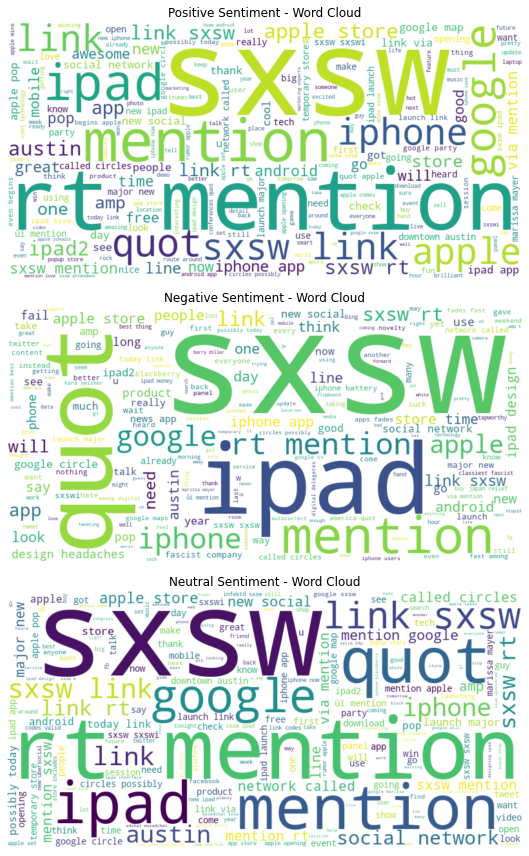

In [8]:
# Generate word clouds for each sentiment category
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_words))

# Plot the word clouds for each sentiment
plt.figure(figsize=(16, 12))

# Positive sentiment word cloud
plt.subplot(3, 1, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment - Word Cloud')

# Negative sentiment word cloud
plt.subplot(3, 1, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment - Word Cloud')

# Neutral sentiment word cloud
plt.subplot(3, 1, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Sentiment - Word Cloud')

plt.tight_layout()
plt.show()

The word clouds reveal that event-related terms like "SXSW", "mention", and "link" dominate across all sentiment categories, indicating that the dataset contains many tweets focused on the SXSW event rather than expressing sentiment. Product-related terms like "iPhone", "iPad", and "Google" are also frequent, but sentiment-specific words are limited. This suggests that pre-processing adjustments, such as removing non-informative terms (e.g., mentions, links, hashtags) and refining the handling of product-specific words, could help improve sentiment analysis.

### Data Preparation

In [9]:
# Clean the data
# Drop rows with missing tweet_text and drop the column 'emotion_in_tweet_is_directed_at' as it is not necessary for sentiment analysis
cleaned_tweet_data = tweet_data.dropna(subset=['tweet_text']).drop(columns=['emotion_in_tweet_is_directed_at'])

# Display the cleaned dataset for further inspection
cleaned_tweet_data.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [10]:
# Cross-checking that there are no missing values
missing_values = cleaned_tweet_data.isnull().sum()

missing_values

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

The dataset has been successfully cleaned by removing the missing entries from the `tweet_text` column and dropping the irrelevant `emotion_in_tweet_is_directed_at` column.

In [11]:
# Perform text-processing
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply the preprocessing function to the 'tweet_text' column
cleaned_tweet_data['cleaned_text'] = cleaned_tweet_data['tweet_text'].apply(preprocess_text)

# Display the first few rows of the preprocessed data
cleaned_tweet_data[['tweet_text', 'cleaned_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\engig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\engig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\engig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley g iphone hr tweeting riseaustin dead ne...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,sxsw hope year festival isnt crashy year iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff fri sxsw marissa mayer g...


The `cleaned_text` column now contains preprocessed Tweet text, which has been:

* Converted to lowercase.
* Stripped of punctuation and special characters.
* Tokenized, with stop words removed.
* Lemmatized to reduce words to their base form.

In [12]:
# Perform feature engineering
# Filter the dataset for only positive and negative sentiments
binary_data = cleaned_tweet_data[cleaned_tweet_data['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion'])]

# Prepare target variable (1 for positive, 0 for negative)
y_binary = binary_data['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else 0)

# Split the binary dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(binary_data['tweet_text'], y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Define the TF-IDF Vectorizer with a maximum of 5000 features and stop words removed
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same TF-IDF model
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Display the shapes of the resulting SMOTE-applied data
(X_train_smote.shape, y_train_smote.shape)

((4764, 5000), (4764,))

The dataset is prepared for binary sentiment analysis by filtering for only positive and negative sentiments. The target variable is created by labeling positive emotions as 1 and negative emotions as 0. The data is then split into training and test sets using an 80/20 ratio. The text data is transformed using a TF-IDF vectorizer, which converts the text into numerical features with a maximum of 5,000 features. Finally, SMOTE (Synthetic Minority Over-sampling Technique) is applied to the training data to address class imbalance, ensuring that both sentiment classes are more equally represented during model training.

## Modeling

### 1. Binary Classification

#### 1a. Logistic Regression

In [13]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Penalty norm (L1 norm is typically supported with 'liblinear' or 'saga')
    'solver': ['liblinear', 'saga']  # Solvers compatible with penalty
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the SMOTE-balanced training data
grid_search.fit(X_train_smote, y_train_smote)

# Display the best hyperparameters found
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best model found by GridSearchCV
best_logreg = grid_search.best_estimator_
y_pred_best = best_logreg.predict(X_test_tfidf)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_best)
report_tuned = classification_report(y_test, y_pred_best, target_names=['Negative', 'Positive'])

# Display the evaluation scores
print(f"Accuracy after Tuning: {accuracy_tuned}")
print("Classification Report after Tuning:\n", report_tuned)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy after Tuning: 0.8816901408450705
Classification Report after Tuning:
               precision    recall  f1-score   support

    Negative       0.64      0.61      0.62       114
    Positive       0.93      0.93      0.93       596

    accuracy                           0.88       710
   macro avg       0.78      0.77      0.78       710
weighted avg       0.88      0.88      0.88       710



Results for the binary classification task with a tuned logistic regression model:

* **Accuracy:** 88%  
  The model shows a strong overall accuracy of 88%, meaning it correctly classifies a large majority of the tweets. However, this metric could be influenced by the class imbalance, where positive tweets dominate the dataset.

* **Negative Class (Precision: 0.64, Recall: 0.61, F1-score: 0.62):**  
  The model performs moderately well at predicting negative sentiment. A precision of 0.64 indicates that 64% of the predicted negative sentiments are correct, while a recall of 0.61 means the model captures 61% of all actual negative sentiments. The F1-score of 0.62 suggests a fair balance between precision and recall, but there’s room for improvement, especially in recall, to ensure more negative cases are correctly identified.

* **Positive Class (Precision: 0.93, Recall: 0.93, F1-score: 0.93):**  
  The model excels at classifying positive sentiment, with both precision and recall at 0.93. This shows that the model is highly effective at identifying positive tweets and has very few false positives or missed positive cases. The high F1-score of 0.93 confirms the model's consistency and reliability in identifying positive sentiment. 

Overall, while the model performs very well with positive sentiment, improving the recall for the negative class could enhance its overall performance.

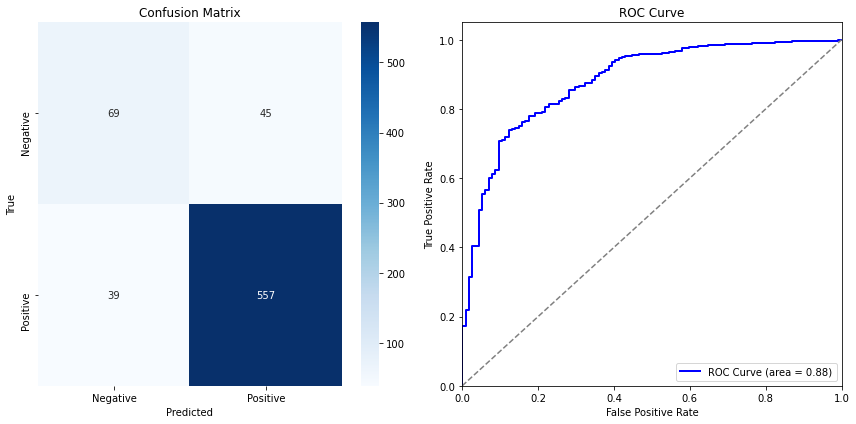

In [14]:
# Step 1: Confusion Matrix
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Step 2: AUC-ROC Curve
# Logistic Regression gives decision function outputs (confidence scores) for calculating ROC
y_proba = best_logreg.predict_proba(X_test_tfidf)[:, 1]  # Get probabilities for the positive class

# Compute false positive rate, true positive rate and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Step 3: Plot Confusion Matrix and ROC Curve on the Same Graph
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

# ROC Curve Plot
ax[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_title("ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend(loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()

The confusion matrix shows a strong performance in identifying positive tweets, with relatively few false negatives. However, there is a moderate number of false positives, indicating some confusion between the two classes.

The ROC curve displays the trade-off between the true positive rate (recall) and false positive rate at various thresholds. The AUC (Area Under the Curve) is 0.88, which suggests that the logistic regression model has good discriminatory power. An AUC close to 1 indicates excellent performance, while a score of 0.88 reflects a model that performs well at distinguishing between the positive and negative classes.

#### 1b. Random Forest

In [15]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt']   # Number of features to consider at each split
}

# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up GridSearchCV with 3-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the SMOTE-balanced training data
grid_search_rf.fit(X_train_smote, y_train_smote)

# Display the best hyperparameters found
best_params_rf = grid_search_rf.best_params_
print(f"Best Parameters: {best_params_rf}")

# Train the best model found by GridSearchCV
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_tfidf)

# Evaluate the tuned model
accuracy_tuned_rf = accuracy_score(y_test, y_pred_best_rf)
report_tuned_rf = classification_report(y_test, y_pred_best_rf, target_names=['Negative', 'Positive'])

# Display the evaluation scores
print(f"Accuracy after Tuning: {accuracy_tuned_rf}")
print("Classification Report after Tuning:\n", report_tuned_rf)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy after Tuning: 0.8816901408450705
Classification Report after Tuning:
               precision    recall  f1-score   support

    Negative       0.79      0.36      0.49       114
    Positive       0.89      0.98      0.93       596

    accuracy                           0.88       710
   macro avg       0.84      0.67      0.71       710
weighted avg       0.87      0.88      0.86       710



Results for the binary classification task with a tuned random forest model:

* **Accuracy:** 88%  
  The model achieves an overall accuracy of 88%, which indicates it performs well in classifying both positive and negative sentiments. However, the performance between the two classes varies significantly.

* **Negative Class (Precision: 0.79, Recall: 0.36, F1-score: 0.49):**  
  The model performs relatively well in terms of precision for negative sentiment, with a precision score of 0.79. This means that when the model predicts negative sentiment, it is correct 79% of the time. However, the recall is quite low at 0.36, meaning the model only captures 36% of actual negative sentiments. This leads to an F1-score of 0.49, indicating that the model struggles to identify negative tweets accurately, primarily due to the low recall. Improving the recall could significantly enhance the model's performance for negative sentiment detection.

* **Positive Class (Precision: 0.89, Recall: 0.98, F1-score: 0.93):**  
  The model performs very well at identifying positive sentiment, with a high precision of 0.89 and an even higher recall of 0.98. This indicates that the model correctly identifies almost all positive tweets and has very few false positives. The F1-score of 0.93 reflects the strong overall performance for the positive class.

Overall, while the model excels at predicting positive sentiment, the low recall for negative sentiment shows that it misses a large number of negative tweets. Balancing the performance for both classes would be beneficial to ensure that the model doesn’t overly favor the positive class at the expense of missing negative cases.

#### 1c. Support Vector Machine (SVM)

In [16]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Linear or RBF kernel
    'gamma': [0.01, 0.1, 1, 10]  # Kernel coefficient for non-linear kernels
}

# Initialize the SVM model
svm_model = SVC(class_weight='balanced', random_state=42)

# Set up GridSearchCV with cross-validation
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the SMOTE-balanced training data
grid_search_svm.fit(X_train_smote, y_train_smote)

# Display the best hyperparameters found
best_params_svm = grid_search_svm.best_params_
print(f"Best Parameters for SVM: {best_params_svm}")

# Train the best model found by GridSearchCV
best_svm = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_tfidf)

# Evaluate the tuned SVM model
accuracy_svm = accuracy_score(y_test, y_pred_best_svm)
report_svm = classification_report(y_test, y_pred_best_svm, target_names=['Negative', 'Positive'])

# Display the evaluation scores
print(f"Accuracy after SVM Tuning: {accuracy_svm}")
print("Classification Report after SVM Tuning:\n", report_svm)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters for SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Accuracy after SVM Tuning: 0.8901408450704226
Classification Report after SVM Tuning:
               precision    recall  f1-score   support

    Negative       0.81      0.41      0.55       114
    Positive       0.90      0.98      0.94       596

    accuracy                           0.89       710
   macro avg       0.85      0.70      0.74       710
weighted avg       0.88      0.89      0.87       710



Results for the binary classification task with a tuned SVM model:

* **Accuracy:** 89%  
  The model demonstrates strong overall accuracy at 89%, indicating good performance in correctly classifying tweets as either positive or negative sentiments. 

* **Negative Class (Precision: 0.81, Recall: 0.41, F1-score: 0.55):**  
  The precision for the negative class is reasonably high at 0.81, which suggests that when the model predicts negative sentiment, 81% of those predictions are correct. However, the recall for the negative class is quite low at 0.41, meaning the model only correctly identifies 41% of the actual negative tweets. This results in a lower F1-score of 0.55, highlighting the model’s struggle to consistently detect negative sentiments. Improving recall would help better identify more negative cases.

* **Positive Class (Precision: 0.90, Recall: 0.98, F1-score: 0.94):**  
  The model performs excellently with positive sentiment classification. Precision is 0.90, and the recall is very high at 0.98, meaning the model is both confident and highly accurate in detecting positive tweets. The F1-score of 0.94 reflects a strong balance between precision and recall for the positive class.

Overall, while the SVM model achieves great performance in identifying positive sentiments, it struggles to capture a sufficient number of negative tweets due to the low recall. As with previous models, balancing the performance between the two classes, particularly improving recall for negative sentiment, would improve the model's robustness.

### Binary Classification Summary:

For generalized sentiment analysis, **Logistic Regression** is recommended as the most balanced model. It achieves an overall accuracy of **88%**, with a well-rounded performance across both positive and negative sentiment classes. For the negative class, Logistic Regression has a recall of **0.61**, which is significantly better than both Random Forest (0.36) and SVM (0.41). This higher recall means Logistic Regression captures more actual negative tweets compared to the other models. The F1-score for the negative class is also the highest among the three models at **0.62**, showing a more reliable balance between precision and recall for this more challenging class.

In contrast, while **SVM** achieves the highest overall accuracy at **89%**, it struggles with negative sentiment, reflected in a recall of **0.41** and an F1-score of **0.55**. **Random Forest** performs similarly, with a recall of **0.36** and an F1-score of **0.49** for the negative class. Both SVM and Random Forest perform well with positive sentiment but fall short in detecting negative sentiments. Therefore, **Logistic Regression**, with its better performance in negative sentiment detection, is the more reliable choice for sentiment analysis, where capturing both positive and negative sentiments is essential.

### 2. Multiclass Classification

In [17]:
# Filter relevant rows and map sentiment labels to numerical categories
multiclass_data = cleaned_tweet_data[cleaned_tweet_data['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion', 'No emotion toward brand or product'])]

# Define the target variable (sentiment)
y_multiclass = multiclass_data['is_there_an_emotion_directed_at_a_brand_or_product'].map({
    'Positive emotion': 1,
    'Negative emotion': 0,
    'No emotion toward brand or product': 2
})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(multiclass_data['tweet_text'], y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass)

# Define the TF-IDF Vectorizer with a maximum of 5000 features and stop words removed
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Fit and transform the training text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same TF-IDF model
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Display the shapes of the resulting SMOTE-applied data
(X_train_smote.shape, y_train_smote.shape)

((12930, 5000), (12930,))

#### 2a. Multinomial Naive Bayes

In [18]:
# Initialize the Multinomial Naive Bayes model
nb = MultinomialNB()

# Define a grid of parameters to search over
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Try different smoothing parameters
    'fit_prior': [True, False]  # Whether to learn class prior probabilities or assume uniform
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model with different hyperparameter combinations
grid_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Negative', 'Positive', 'Neutral'])

# Display the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Best Hyperparameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy: 0.6135346756152126
Classification Report:
               precision    recall  f1-score   support

    Negative       0.32      0.50      0.39       114
    Positive       0.51      0.66      0.58       596
     Neutral       0.77      0.60      0.67      1078

    accuracy                           0.61      1788
   macro avg       0.53      0.59      0.55      1788
weighted avg       0.65      0.61      0.62      1788



Results for the multiclass classification task with a Multinomial Naive Bayes model:

* **Accuracy:** 61%  
  The overall accuracy of 61% suggests that the model is correctly classifying the sentiment categories (negative, positive, and neutral) about 61% of the time. This is relatively modest, indicating that there is room for improvement, particularly in distinguishing the negative and positive sentiments.

* **Negative Class (Precision: 0.32, Recall: 0.50, F1-score: 0.39):**  
  The model struggles significantly with the negative class. The precision of 0.32 indicates that only 32% of the tweets predicted as negative were actually negative, suggesting a high number of false positives. The recall is better at 0.50, meaning the model correctly identifies 50% of all actual negative tweets. However, the low F1-score of 0.39 reflects the poor balance between precision and recall for this class.

* **Positive Class (Precision: 0.51, Recall: 0.66, F1-score: 0.58):**  
  For the positive class, the precision is 0.51, indicating that the model is moderately accurate in identifying positive tweets. The recall of 0.66 shows that it correctly identifies 66% of the actual positive tweets, but with false positives as well. The F1-score of 0.58 suggests a more reasonable balance between precision and recall, but there is still room for improvement.

* **Neutral Class (Precision: 0.77, Recall: 0.60, F1-score: 0.67):**  
  The model performs best with neutral sentiment, achieving a precision of 0.77 and an F1-score of 0.67. This shows that it is relatively reliable in identifying neutral tweets, with fewer false positives compared to the other classes. The recall of 0.60 means it captures 60% of all neutral tweets, but some neutral tweets are missed.

Overall, this multinomial Naive Bayes model performs reasonably well on neutral sentiment but struggles significantly with negative and positive sentiments. The low precision for negative sentiment (0.32) suggests a high rate of false positives, while the moderate F1-score for positive sentiment (0.58) suggests the model is better but still not strong in identifying positive tweets. To improve overall performance, focusing on boosting precision for the negative and positive classes will be crucial, possibly by improving the feature selection or exploring more sophisticated models.

#### 2b. Voting Classifier

In [19]:
# Initialize the Naive Bayes and Random Forest models
nb = MultinomialNB(alpha=0.1, fit_prior=True)  # Tuned Naive Bayes with best alpha
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)  # Tuned Random Forest

# Create a Voting Classifier (soft voting)
voting_clf = VotingClassifier(estimators=[('rf', rf), ('nb', nb)], voting='soft')

# Fit the Voting Classifier on the SMOTE-balanced training data
voting_clf.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = voting_clf.predict(X_test_tfidf)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Negative', 'Positive', 'Neutral'])

# Display the evaluation metrics
print(f"Ensemble Model Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Ensemble Model Accuracy: 0.6778523489932886
Classification Report:
               precision    recall  f1-score   support

    Negative       0.44      0.43      0.43       114
    Positive       0.59      0.62      0.60       596
     Neutral       0.76      0.74      0.75      1078

    accuracy                           0.68      1788
   macro avg       0.59      0.59      0.59      1788
weighted avg       0.68      0.68      0.68      1788



Results for the multiclass classification task with an ensemble model (Multinomial Naive Bayes plus Random Forest):

* **Accuracy:** 68%  
  The ensemble model achieves an accuracy of 68%, which is an improvement over the previous Naive Bayes model’s accuracy of 61%. The ensemble approach seems to have led to better performance, particularly for neutral and positive classes, while negative sentiment still remains challenging.

* **Negative Class (Precision: 0.44, Recall: 0.43, F1-score: 0.43):**  
  The precision and recall for the negative class have slightly improved compared to the Naive Bayes model. With a precision of 0.44 and a recall of 0.43, the model correctly identifies 43% of actual negative tweets and has a modest balance between precision and recall (F1-score: 0.43). However, there’s still room for improvement in detecting negative sentiments, as the model frequently misclassifies or misses negative tweets.

* **Positive Class (Precision: 0.59, Recall: 0.62, F1-score: 0.60):**  
  The performance for the positive class shows a noticeable improvement, with precision of 0.59 and recall of 0.62. The F1-score of 0.60 indicates a balanced performance in identifying positive tweets, meaning the model is reasonably effective at capturing positive sentiment, although there is still some noise (false positives).

* **Neutral Class (Precision: 0.76, Recall: 0.74, F1-score: 0.75):**  
  The neutral class continues to perform well, with the highest precision (0.76) and F1-score (0.75) among all classes. The model reliably identifies neutral sentiment, as reflected by the high recall of 0.74, meaning most neutral tweets are correctly classified. This consistent performance for the neutral class boosts the overall accuracy of the model.

Overall, the ensemble model has improved the overall accuracy (68%) and performance across all classes compared to the previous Naive Bayes model. While neutral sentiment remains the easiest for the model to classify, performance for the positive class has improved (F1-score of 0.60), and there are slight improvements in detecting negative sentiment.

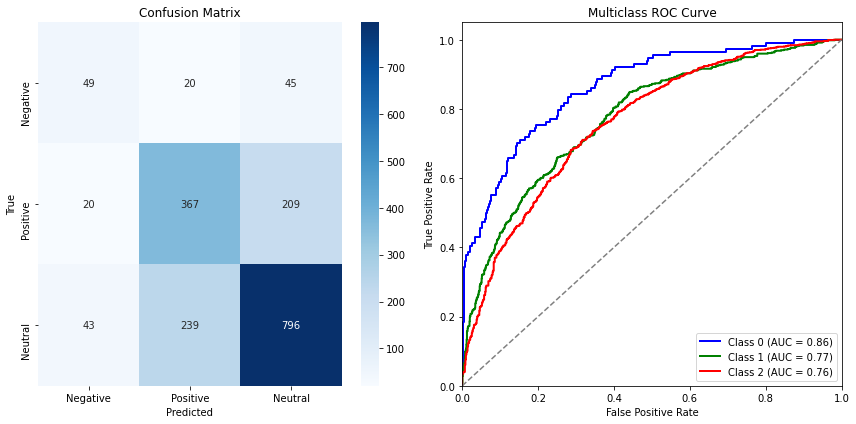

In [20]:
# Step 1: Confusion Matrix
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 2: AUC-ROC for Multiclass
# We need to binarize the output for the ROC curve (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 0: Negative, 1: Positive, 2: Neutral
y_pred_proba = voting_clf.predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot Confusion Matrix and AUC-ROC Curve on the Same Graph
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'], ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

# ROC Curve Plot
colors = ['blue', 'green', 'red']
for i, color in zip(range(3), colors):
    ax[1].plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_title("Multiclass ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend(loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()

The confusion matrix indicates that the model performs reasonably well on neutral and positive classes but struggles more with distinguishing between neutral and positive tweets, as seen by the higher misclassification rates between these two classes.

The AUC scores show that the model is particularly good at distinguishing negative tweets from the others, while the performance for positive and neutral classes is moderate but less reliable, with some overlap between these classes.

### Multiclass Classification Summary:

Comparing the two models, the **ensemble model** (Multinomial Naive Bayes + Random Forest) clearly outperforms the standalone **Multinomial Naive Bayes model**. The ensemble model achieves a higher accuracy of **68%** compared to Naive Bayes' **61%**, and its performance across all classes is more balanced. For the negative class, the ensemble model improves precision from **0.32 to 0.44** and F1-score from **0.39 to 0.43**, indicating fewer false positives and better overall identification of negative sentiments. Similarly, for the positive class, the ensemble model's F1-score of **0.60** surpasses Naive Bayes' F1-score of **0.58**, showing an improved ability to capture positive tweets.

The ensemble model's strength lies in its significantly better performance with the neutral class (F1-score of **0.75** vs. **0.67** in Naive Bayes), which helps boost its overall metrics. Given its superior accuracy, balanced performance across all sentiment classes, and better handling of both positive and negative sentiment, the **ensemble model** would be the preferred choice for generalized sentiment analysis in the multiclass classification task. It provides more reliable results across all sentiment categories, making it a more robust option for real-world applications.

## Evaluation Metrics

The evaluation metrics used so far include Accuracy (proportion of correctly classified instances (both positive, negative, and neutral sentiments) out of the total instances), Precision (ratio of correctly predicted positive instances to the total instances predicted as positive), Recall (model's ability to identify all relevant instances of a class) and F1-Score (harmonic mean of precision and recall, providing a balanced metric when both precision and recall are important). The higher the metric, the better.


In the context of generalized sentiment analysis, **F1-score** would be the most important metric to consider, as it balances both **precision** and **recall**. Given that the dataset includes several classes, it is crucial not only to correctly classify the sentiments (precision) but also to capture as many relevant examples of each class as possible (recall). F1-score helps ensure that the model performs well across different classes without favoring one over the others, which is particularly important in cases of class imbalance like this one. Thus, while accuracy provides a general overview, the F1-score offers a more nuanced view of model performance across all sentiment categories.

We also included a confusion matrix (to show the true and predicted classes for each category) and AUC-ROC (to plot the true positive rate (recall) against the false positive rate at various threshold levels) charts for best performing models in each classification category.

## Conclusion

The results of this project demonstrate the successful development of an NLP sentiment classification model aimed at analyzing consumer sentiment toward Apple and Google products on Twitter. For binary classification, Logistic Regression proved to be the most balanced model, achieving an accuracy of 88%, with a particularly strong performance in detecting negative sentiment. This is critical for stakeholders since negative sentiment often highlights areas for improvement in products and services. In the multiclass classification task, the ensemble model (Multinomial Naive Bayes + Random Forest) outperformed the standalone Naive Bayes model, achieving 68% accuracy with a well-balanced performance across positive, negative, and neutral sentiment classes. This indicates that the model can reliably provide actionable insights across all sentiment categories, helping Apple and Google make informed decisions about their products and customer engagement.

The project successfully met its primary objectives by building robust general sentiment classification models that can be deployed to provide relevant insights to the marketing and product development teams at Apple and Google. The models were able to capture both positive and negative sentiments, with a special emphasis on improving the detection of negative sentiment, which is vital for addressing public concerns and enhancing product strategies. The ensemble model's superior performance in the multiclass task further ensures that neutral sentiments are well-handled, providing a comprehensive view of consumer opinions.

### Recommendations:

Based on the results and the nature of the data, the next steps should focus on:

- **Improve Detection of Negative Sentiment**: Focus on enhancing the model’s ability to capture negative sentiments by exploring advanced techniques like **phrase extraction** or more sophisticated models such as BERT to capture nuanced expressions of negativity.
  
- **Address Class Imbalance**: Consider collecting more diverse data to better balance the representation of sentiment classes, particularly negative sentiment, which is often underrepresented in the dataset.

- **Refine Pre-processing**: Implement more detailed pre-processing techniques (e.g., handling negations, domain-specific words) to improve model performance across all sentiment classes.

- **Ongoing Monitoring and Retraining**: Regularly monitor and retrain the model as the social media landscape and consumer sentiment evolve, ensuring that the model continues to provide accurate insights over time.